In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import utils.config as config
from utils.datasets import build_dataset
from models.registry import MODELS_REGISTRY
import time

2026-01-27 21:17:05.666907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-27 21:17:05.666965: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-27 21:17:05.666982: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-27 21:17:05.672051: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-27 21:17:06.333327: W tensorflow/compiler/

🚀 Running quick layer-wise explanation

🔍 Starting layer-wise analysis for class 2
   Step 1/2: Model prediction
   Step 2/2: Computing Conv2D feature maps
   Collected 14 layer maps


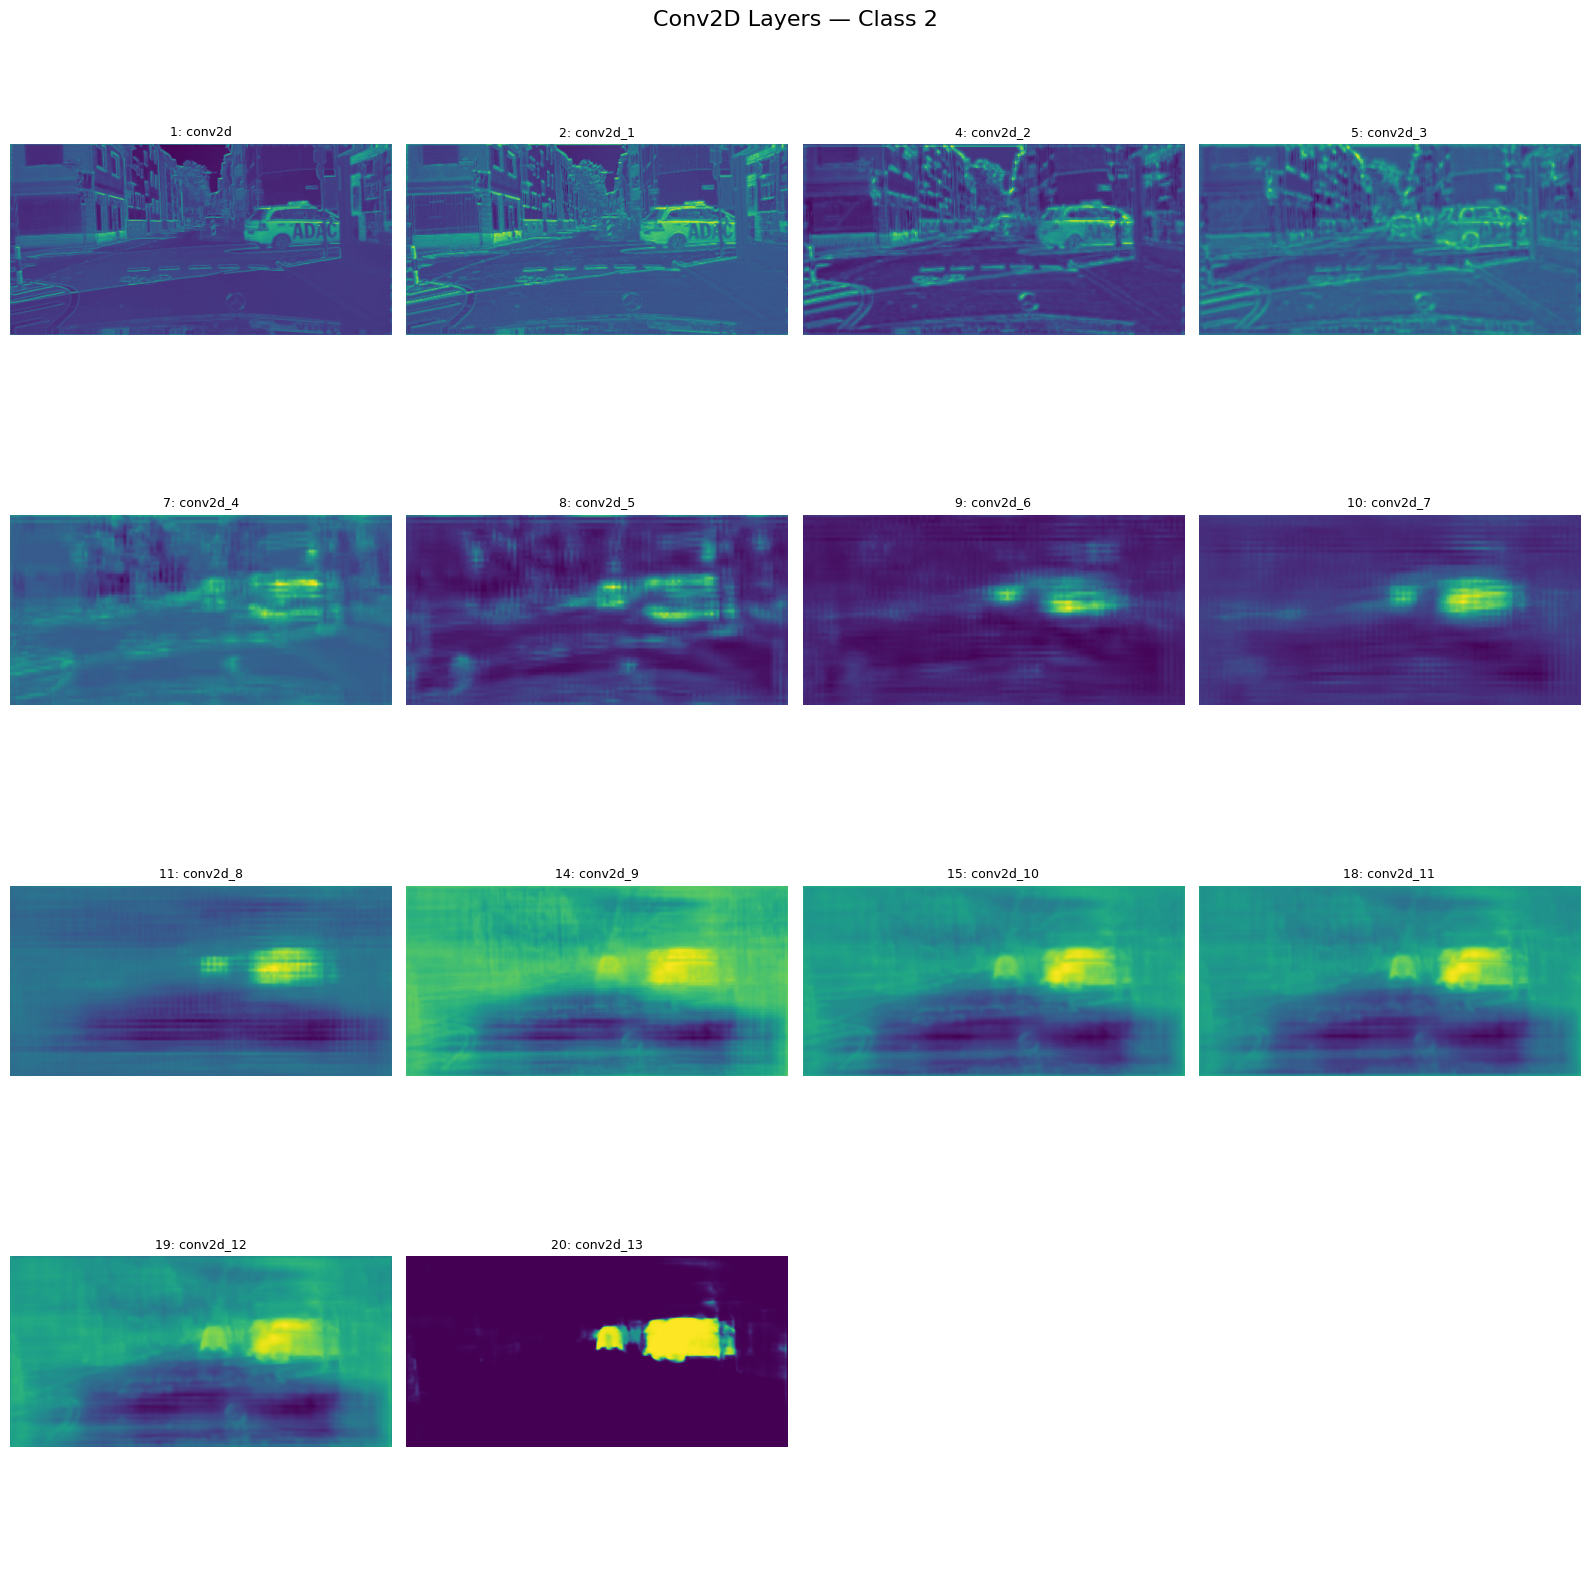

✅ Analysis complete.
   IoU: 0.834

🔍 Starting layer-wise analysis for class 2
   Step 1/2: Model prediction
   Step 2/2: Computing Conv2D feature maps
   Collected 14 layer maps


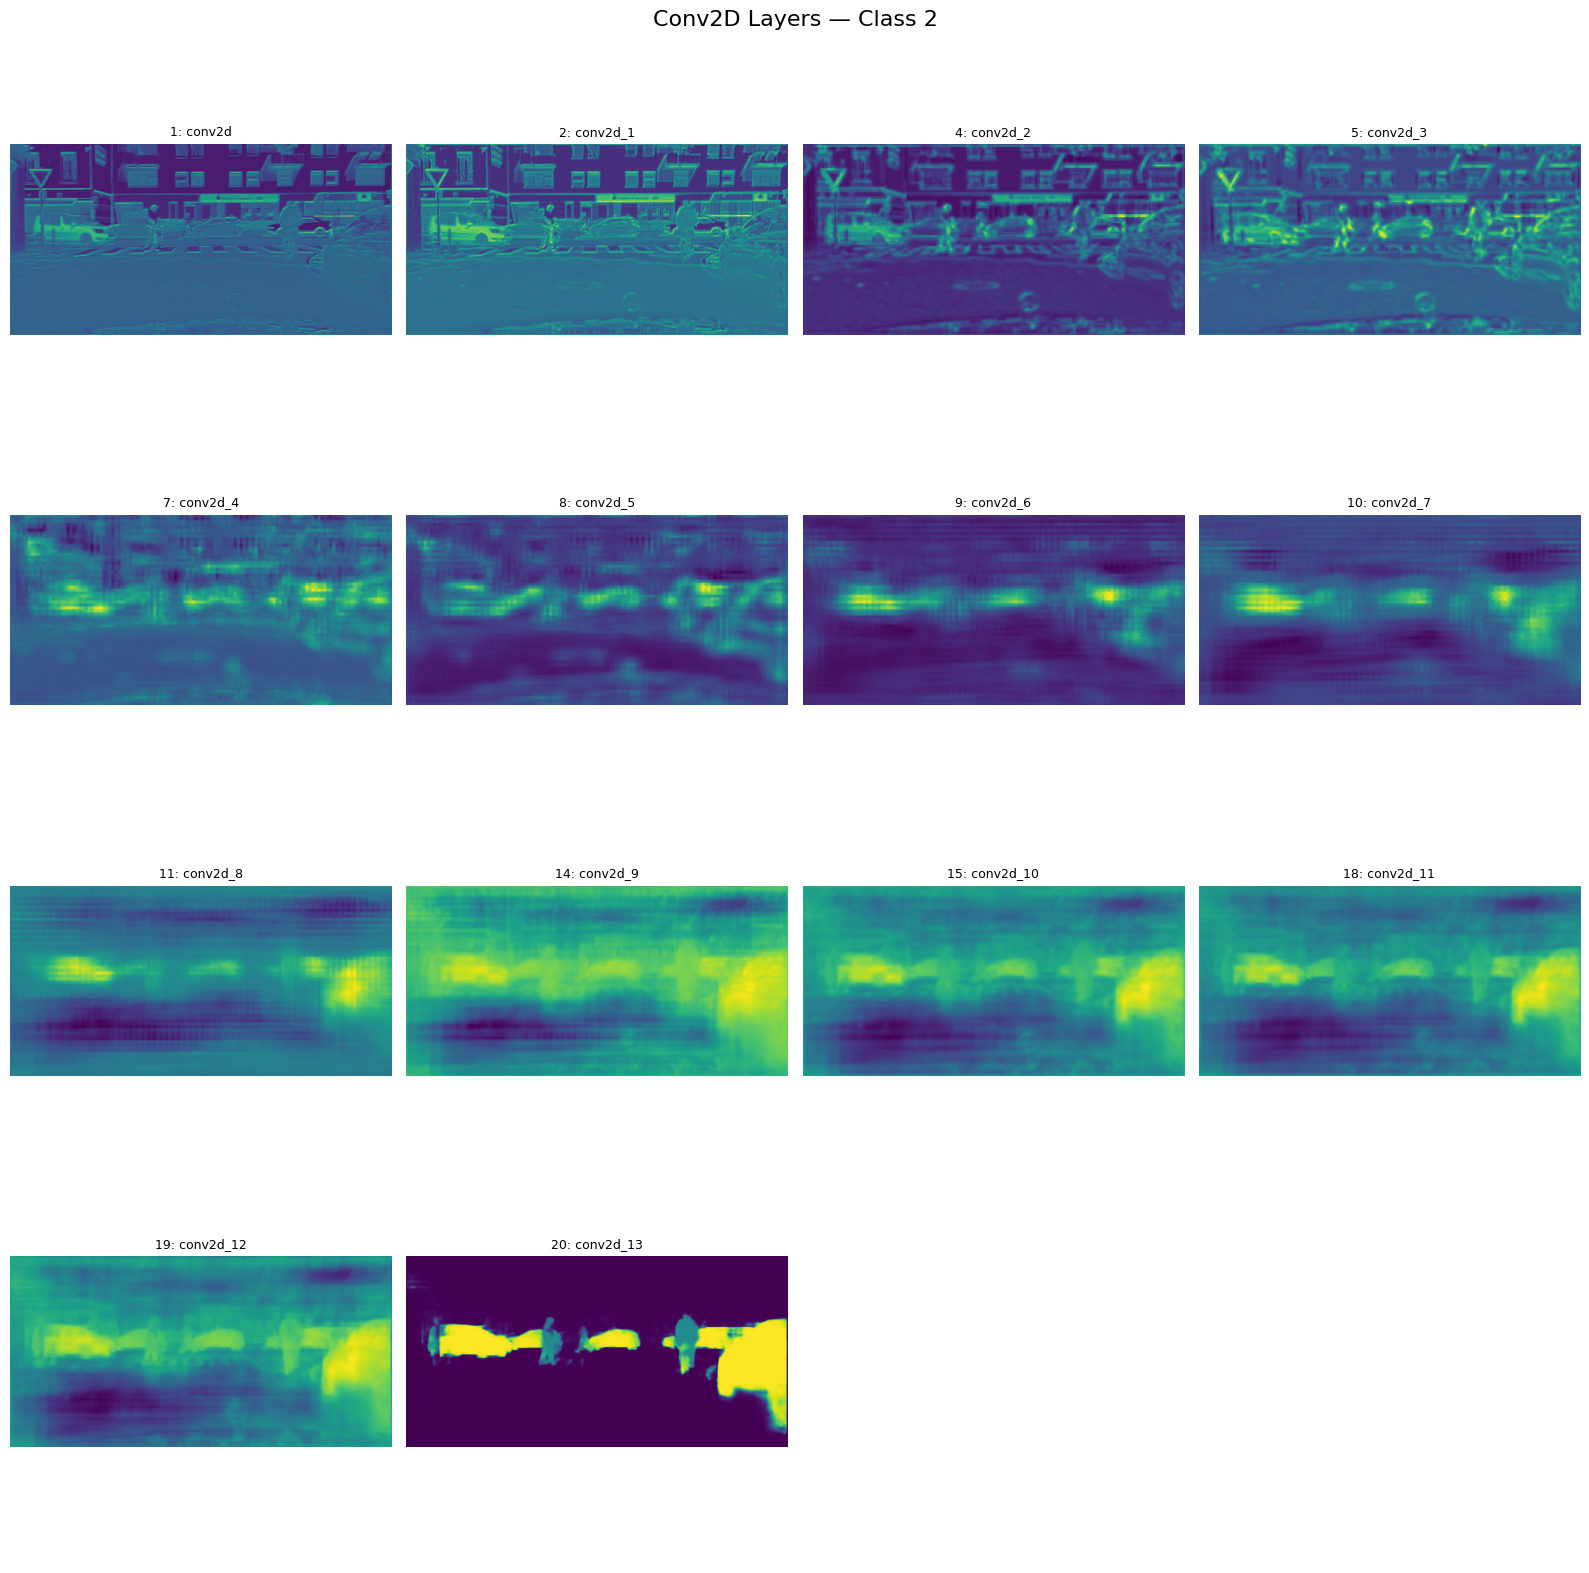

✅ Analysis complete.
   IoU: 0.821
🚀 Running quick layer-wise explanation

🔍 Starting layer-wise analysis for class 1
   Step 1/2: Model prediction
   Step 2/2: Computing Conv2D feature maps
   Collected 14 layer maps


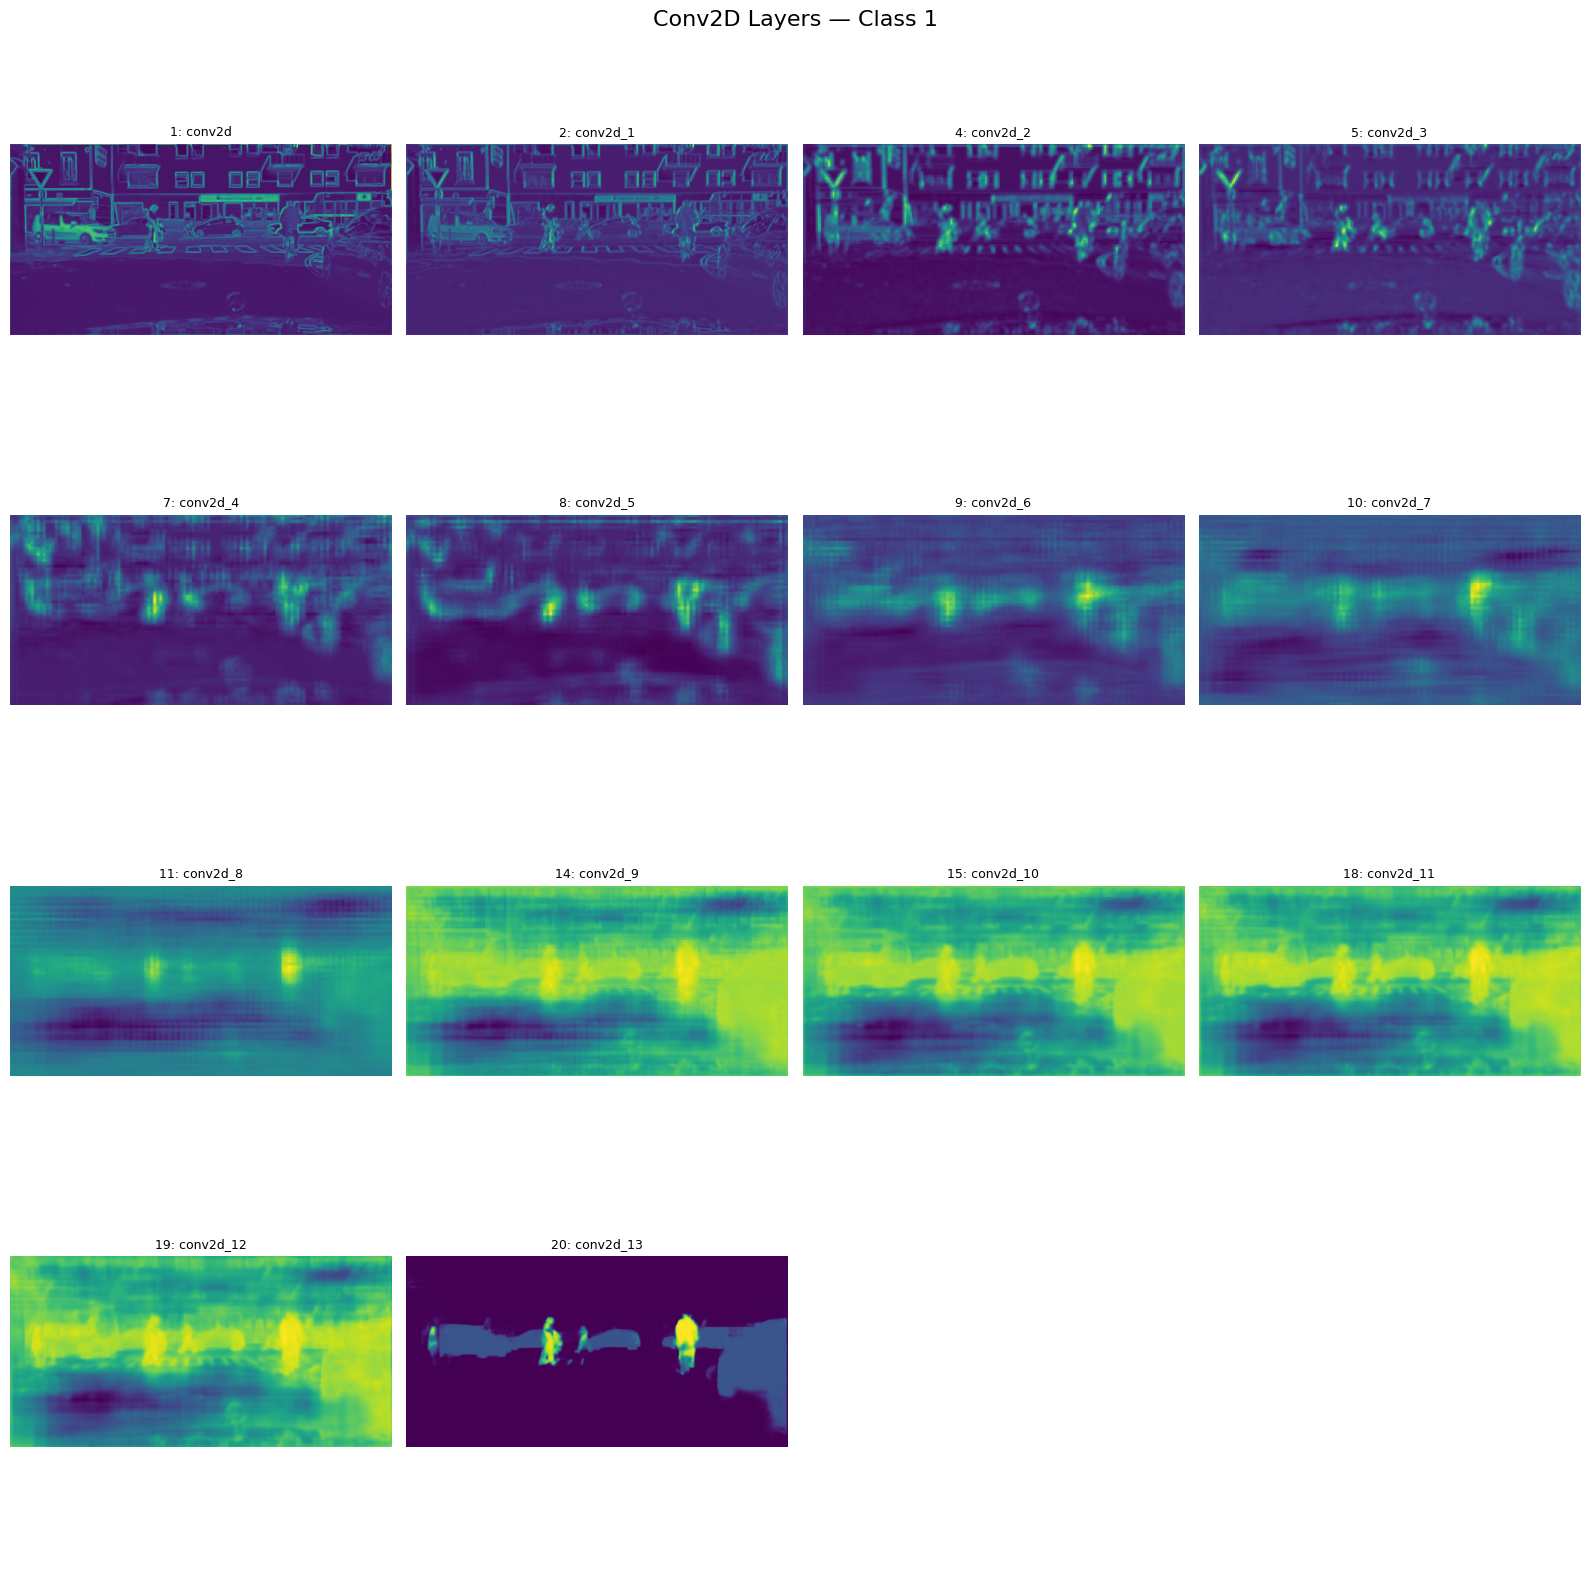

✅ Analysis complete.
   IoU: 0.821


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def compute_single_layer_map(
    model,
    image_tensor,
    class_probs,
    layer
):
    partial_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=layer.output
    )

    features = partial_model.predict(image_tensor, verbose=0)[0]

    if features.ndim != 3:
        return None

    h, w = features.shape[:2]
    resized_probs = tf.image.resize(
        class_probs[..., None], (h, w)
    ).numpy().squeeze()

    weights = []
    for ch in range(features.shape[-1]):
        f = features[..., ch]
        if np.std(f) > 0 and np.std(resized_probs) > 0:
            corr = np.corrcoef(f.ravel(), resized_probs.ravel())[0, 1]
        else:
            corr = 0.0
        weights.append(corr)

    weights = np.nan_to_num(np.array(weights))
    single_map = np.sum(features * weights, axis=-1)

    single_map = (single_map - single_map.min()) / (
        single_map.ptp() + 1e-8
    )

    del partial_model, features
    return single_map


def memory_efficient_unet_analysis(
    model,
    image,
    gt_mask=None,
    class_index=0,
    n_cols=4
):
    print(f"\n🔍 Starting layer-wise analysis for class {class_index}")

    if image.ndim == 3 and image.shape[-1] != 3:
        image = np.repeat(image, 3, axis=-1)

    image_tensor = tf.convert_to_tensor(image[None], tf.float32)

    print("   Step 1/2: Model prediction")
    pred = model.predict(image_tensor, verbose=0)

    if isinstance(pred, dict):
        pred = list(pred.values())[0]

    pred = pred[0]
    pred_class = np.argmax(pred, axis=-1)
    class_probs = pred[..., class_index]

    print("   Step 2/2: Computing Conv2D feature maps")

    conv_layers = [
        (i, layer)
        for i, layer in enumerate(model.layers)
        if isinstance(layer, tf.keras.layers.Conv2D)
    ]

    layer_maps = []

    for layer_idx, layer in conv_layers:
        try:
            fmap = compute_single_layer_map(
                model,
                image_tensor,
                class_probs,
                layer
            )
            if fmap is not None:
                layer_maps.append((layer_idx, layer.name, fmap))
        except Exception as e:
            print(f"   ❌ Failed at {layer.name}: {e}")

    print(f"   Collected {len(layer_maps)} layer maps")

    n_layers = len(layer_maps)
    n_rows = int(np.ceil(n_layers / n_cols))

    fig, axs = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 4 * n_rows)
    )

    axs = np.array(axs).reshape(-1)

    for ax in axs:
        ax.axis("off")

    for i, (layer_idx, layer_name, fmap) in enumerate(layer_maps):
        axs[i].imshow(fmap, cmap="viridis")
        axs[i].set_title(f"{layer_idx}: {layer_name}", fontsize=9)
        axs[i].axis("off")

    plt.suptitle(
        f"Conv2D Layers — Class {class_index}",
        fontsize=16
    )
    plt.tight_layout()
    plt.show()

    print("✅ Analysis complete.")
    return pred_class


def compute_iou(pred, gt, num_classes=3):
    if gt is None:
        return 0.0

    ious = []
    for cls in range(num_classes):
        p = pred == cls
        g = gt == cls
        union = np.logical_or(p, g).sum()
        if union == 0:
            continue
        ious.append(np.logical_and(p, g).sum() / union)

    return float(np.mean(ious)) if ious else 0.0


def quick_test_explanation(
    model,
    samples_indexes=[0],
    class_index=0
):
    from utils.datasets import build_dataset
    import utils.config as config

    print("🚀 Running quick layer-wise explanation")

    test_ds = build_dataset(
        config.VAL_X,
        config.VAL_Y,
        batch_size=1,
        shuffle=False,
        augment=False,
    )

    samples = list(test_ds.as_numpy_iterator())

    for i in samples_indexes:
        image, gt = samples[i]
        img = image[0]
        gt_mask = gt[0]

        pred = memory_efficient_unet_analysis(
            model=model,
            image=img,
            gt_mask=gt_mask,
            class_index=class_index
        )

        iou = compute_iou(pred, gt_mask)
        print(f"   IoU: {iou:.3f}")


model = tf.keras.models.load_model(
    "saved_models/testing_architecture/model3_best.h5",
    compile=False
)

quick_test_explanation(
    model,
    samples_indexes=[0,2],
    class_index=2
)

quick_test_explanation(
    model,
    samples_indexes=[2],
    class_index=1
)
